In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, log10

from pathlib import Path
from tqdm import tqdm

In [3]:
TEMP_FILES = Path('../temp-data/photons')

In [4]:
with open(TEMP_FILES / 'meta.dat') as metadata_file:
    metadata = {}
    for line in metadata_file:
        fname, energy, theta, z_first = line.split(', ')
        metadata[fname] = {'theta': float(theta), 'energy': float(energy)}

(array([93., 80., 96., 92., 85., 90., 94., 84., 72., 69.]),
 array([4.4799086 , 4.77905606, 5.07820352, 5.37735098, 5.67649844,
        5.9756459 , 6.27479336, 6.57394082, 6.87308828, 7.17223574,
        7.4713832 ]),
 <BarContainer object of 10 artists>)

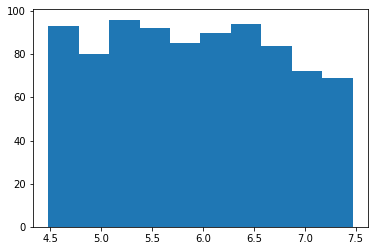

In [5]:
energies = np.array([entry['energy'] for entry in metadata.values()])

plt.hist(np.log10(energies))

In [6]:
def read_hist_dump(file_path):
    with open(file_path) as f:
        f.readline()
        ldf = []
        r = []
        for line in f:
            rmin, rmax, count = [float(s) for s in line.split()]
            # new_counts.append(int(line.split()[2]))
            r.append(0.5 * (rmax + rmin))
            ldf.append(count / (pi*(rmax ** 2 - rmin ** 2)))
    return np.array(r), np.array(ldf)

100%|██████████| 856/856 [00:00<00:00, 35950.70it/s]


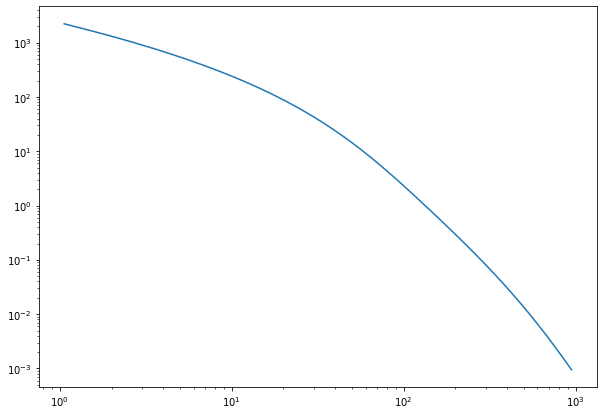

In [7]:
fig, ax = plt.subplots(figsize=[10, 7])

dump_file_paths = [f for f in TEMP_FILES.iterdir() if f.is_file()]

showers_n = 0
counts = None
counts_squared = None

for dat_file_path in tqdm(dump_file_paths):
    shower_metadata = metadata.get(dat_file_path.name, None)
    if not shower_metadata:
        continue
    if shower_metadata['theta'] < (pi * 20 / 180) and abs(log10(shower_metadata['energy']) - 6) < 1:
        rads, new_counts = read_hist_dump(dat_file_path)
        counts = counts + new_counts if counts is not None else new_counts
        counts_squared = counts_squared + np.power(new_counts, 2) if counts_squared is not None else np.power(new_counts, 2)
        showers_n += 1

mean_counts = counts / showers_n

bias_correction = (showers_n / (showers_n-1))
std_counts = np.sqrt(  # M[x^2] - M[x]^2
    bias_correction * ((counts_squared / showers_n) - np.power(mean_counts, 2))
)

ax.plot(rads, mean_counts)
# ax.fill_between(
#     rads, mean_counts-std_counts, mean_counts+std_counts, alpha=0.3, color='red'
# )
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()